In [18]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
#plt.style.use('fivethirtyeight')

In [19]:
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import math
from sklearn.metrics import mean_squared_error
from random import random
import datetime

In [20]:
df = pd.read_excel("/content/pune_tomato_market.xlsx")

In [21]:
df.head()

,Date,Arrival,Price
0,2010-01-03,70.4,1300.0
1,2010-01-04,70.4,1300.0
2,2010-01-05,70.4,1300.0
3,2010-01-06,70.4,1300.0
4,2010-01-07,70.4,1300.0


In [22]:
df.describe()

,Date,Arrival,Price
count,5017,5017.000000,5017.000000
mean,2016-11-15 00:00:00,161.125914,1161.181977
min,2010-01-03 00:00:00,0.100000,200.000000
25%,2013-06-10 00:00:00,111.000000,600.000000
50%,2016-11-15 00:00:00,147.700000,950.000000
75%,2020-04-22 00:00:00,194.000000,1350.000000
max,2023-09-28 00:00:00,2075.000000,8500.000000
std,NaN,97.563156,896.345939


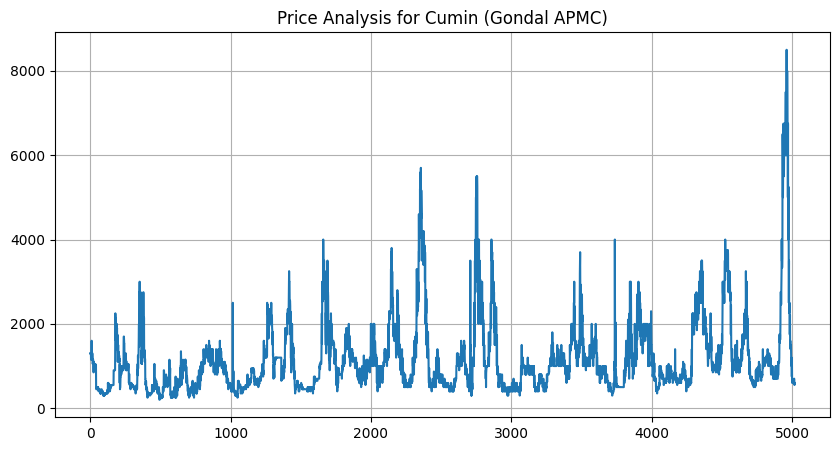

In [23]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(df['Price'])
plt.title('Price Analysis for Cumin (Gondal APMC)')
plt.grid(True)
plt.show()

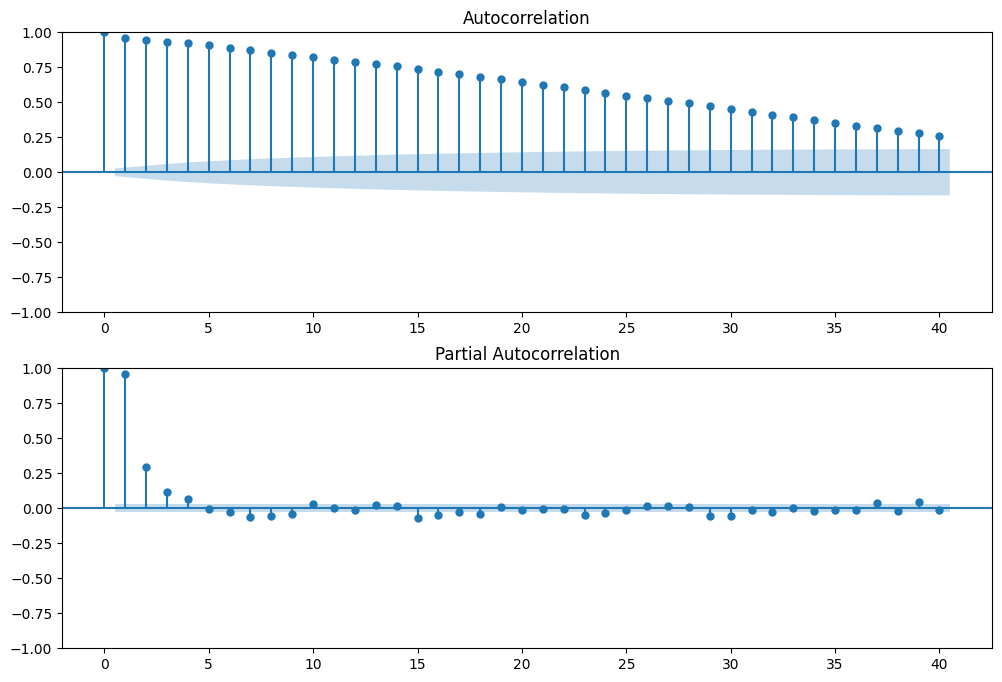

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Price'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Price'], lags=40, ax=ax2)
plt.show()

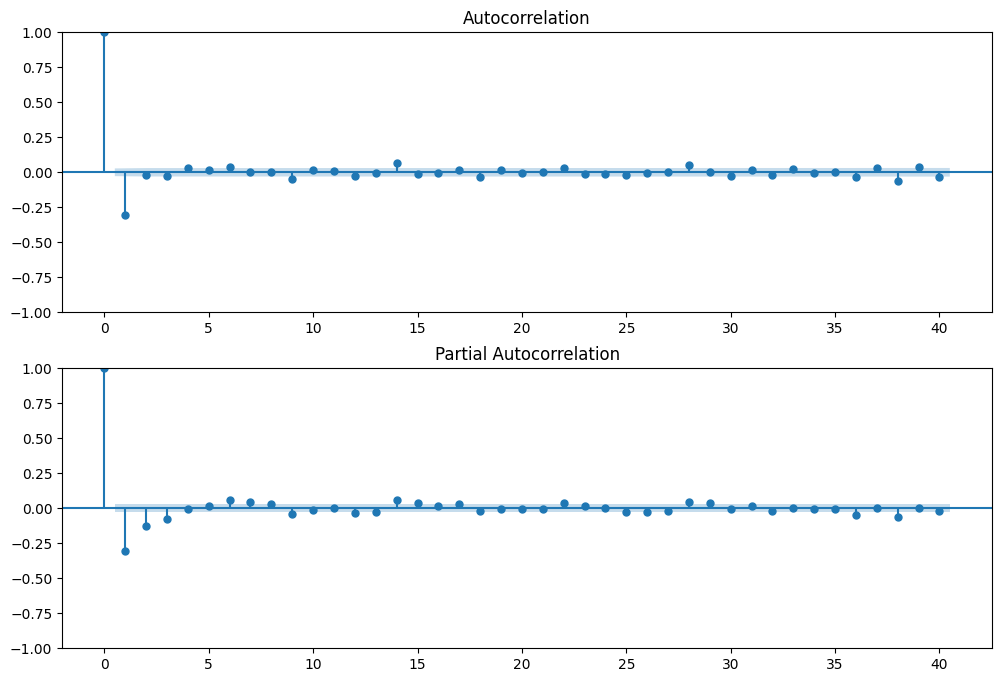

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#Plots with first order differenced Sales variable
fig = sm.graphics.tsa.plot_acf(df['Price'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Price'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [26]:
X = df[['Price', 'Arrival', 'Date']]
# X = X.values

In [27]:
X

,Price,Arrival,Date
0,1300.0,70.4,2010-01-03
1,1300.0,70.4,2010-01-04
2,1300.0,70.4,2010-01-05
3,1300.0,70.4,2010-01-06
4,1300.0,70.4,2010-01-07
...,...,...,...
5012,700.0,235.0,2023-09-24
5013,700.0,223.0,2023-09-25
5014,600.0,246.0,2023-09-26
5015,550.0,166.0,2023-09-27


In [28]:
train_size = int(len(df) * 0.8)
train_data_new = df.iloc[:train_size].reset_index(drop=True)  # Reset index for training data
test_data_new = df.iloc[train_size:].reset_index(drop=True)

In [29]:
test_data_new

,Date,Arrival,Price
0,2020-12-29,148.0,1000.0
1,2020-12-30,135.0,1200.0
2,2020-12-31,175.0,1000.0
3,2021-01-01,239.0,850.0
4,2021-01-02,177.0,1070.0
...,...,...,...
999,2023-09-24,235.0,700.0
1000,2023-09-25,223.0,700.0
1001,2023-09-26,246.0,600.0
1002,2023-09-27,166.0,550.0


In [30]:
test_data_new

,Date,Arrival,Price
0,2020-12-29,148.0,1000.0
1,2020-12-30,135.0,1200.0
2,2020-12-31,175.0,1000.0
3,2021-01-01,239.0,850.0
4,2021-01-02,177.0,1070.0
...,...,...,...
999,2023-09-24,235.0,700.0
1000,2023-09-25,223.0,700.0
1001,2023-09-26,246.0,600.0
1002,2023-09-27,166.0,550.0


In [31]:
# Extract Date index as a list
dates_list = test_data_new['Date'].tolist().copy()
print("Dates List:", dates_list)

Dates List: [Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-03 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-09 00:00:00'), Timestamp('2021-01-10 00:00:00'), Timestamp('2021-01-11 00:00:00'), Timestamp('2021-01-12 00:00:00'), Timestamp('2021-01-13 00:00:00'), Timestamp('2021-01-14 00:00:00'), Timestamp('2021-01-15 00:00:00'), Timestamp('2021-01-16 00:00:00'), Timestamp('2021-01-17 00:00:00'), Timestamp('2021-01-18 00:00:00'), Timestamp('2021-01-19 00:00:00'), Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-21 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-23 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-25 00:00:00'), Timestamp('2021-01-26 00:00:00'), T

In [32]:
# !pip install pmdarima

In [33]:
from pmdarima.arima import auto_arima
import pmdarima as pm

In [34]:
train_data_new

,Date,Arrival,Price
0,2010-01-03,70.4,1300.0
1,2010-01-04,70.4,1300.0
2,2010-01-05,70.4,1300.0
3,2010-01-06,70.4,1300.0
4,2010-01-07,70.4,1300.0
...,...,...,...
4008,2020-12-24,135.0,1000.0
4009,2020-12-25,156.0,1200.0
4010,2020-12-26,155.0,925.0
4011,2020-12-27,188.0,1300.0


In [35]:
test_data_new

,Date,Arrival,Price
0,2020-12-29,148.0,1000.0
1,2020-12-30,135.0,1200.0
2,2020-12-31,175.0,1000.0
3,2021-01-01,239.0,850.0
4,2021-01-02,177.0,1070.0
...,...,...,...
999,2023-09-24,235.0,700.0
1000,2023-09-25,223.0,700.0
1001,2023-09-26,246.0,600.0
1002,2023-09-27,166.0,550.0


In [36]:
# Fit the ARIMAX model with auto_arima
SARIMAX_model = pm.auto_arima(train_data_new['Price'], exogenous=train_data_new[['Arrival']],
                             start_p=0, d=1, start_q=0,
                             max_p=3, max_d=3, max_q=3, start_P=0,
                             D=1, start_Q=0, max_P=3, max_D=3,
                             max_Q=3, m=7, seasonal=True,
                             error_action='warn', trace=True,
                             suppress_warnings=True, stepwise=True,
                             random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=58224.881, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=56475.087, Time=4.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=8.92 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=57769.286, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=56047.390, Time=3.12 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=55699.549, Time=4.79 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=21.15 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=11.97 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=56150.899, Time=1.81 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=55650.919, Time=6.95 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=55996.275, Time=5.16 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=inf, Time=29.49 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=15.35 sec
 ARIMA(3,1,0)(3,1,0)[7]             : AIC=55638.646, Time=7.13 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=559

In [37]:
#Summary of the model
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4013
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 7)   Log Likelihood              -27812.323
Date:                           Sat, 30 Nov 2024   AIC                          55638.646
Time:                                   03:07:06   BIC                          55682.713
Sample:                                        0   HQIC                         55654.266
                                          - 4013                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3706      0.007    -49.719      0.000      -0.385      -0.356
ar.L2         -0.1338      0.009    -15.737      0.000      -0.150      -0.117
ar.L3         -0.0597      0.009     -6.489      0.000      -0.078      -0.042
ar.S.L7       -0.7882      0.008    -97.683      0.000      -0.804      -0.772
ar.S.L14      -0.5214      0.011    -49.530      0.000      -0.542      -0.501
ar.S.L21      -0.2895      0.010    -29.406      0.000      -0.309      -0.270
sigma2      6.292e+04    483.235    130.211      0.000     6.2e+04    6.39e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             39099.54
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

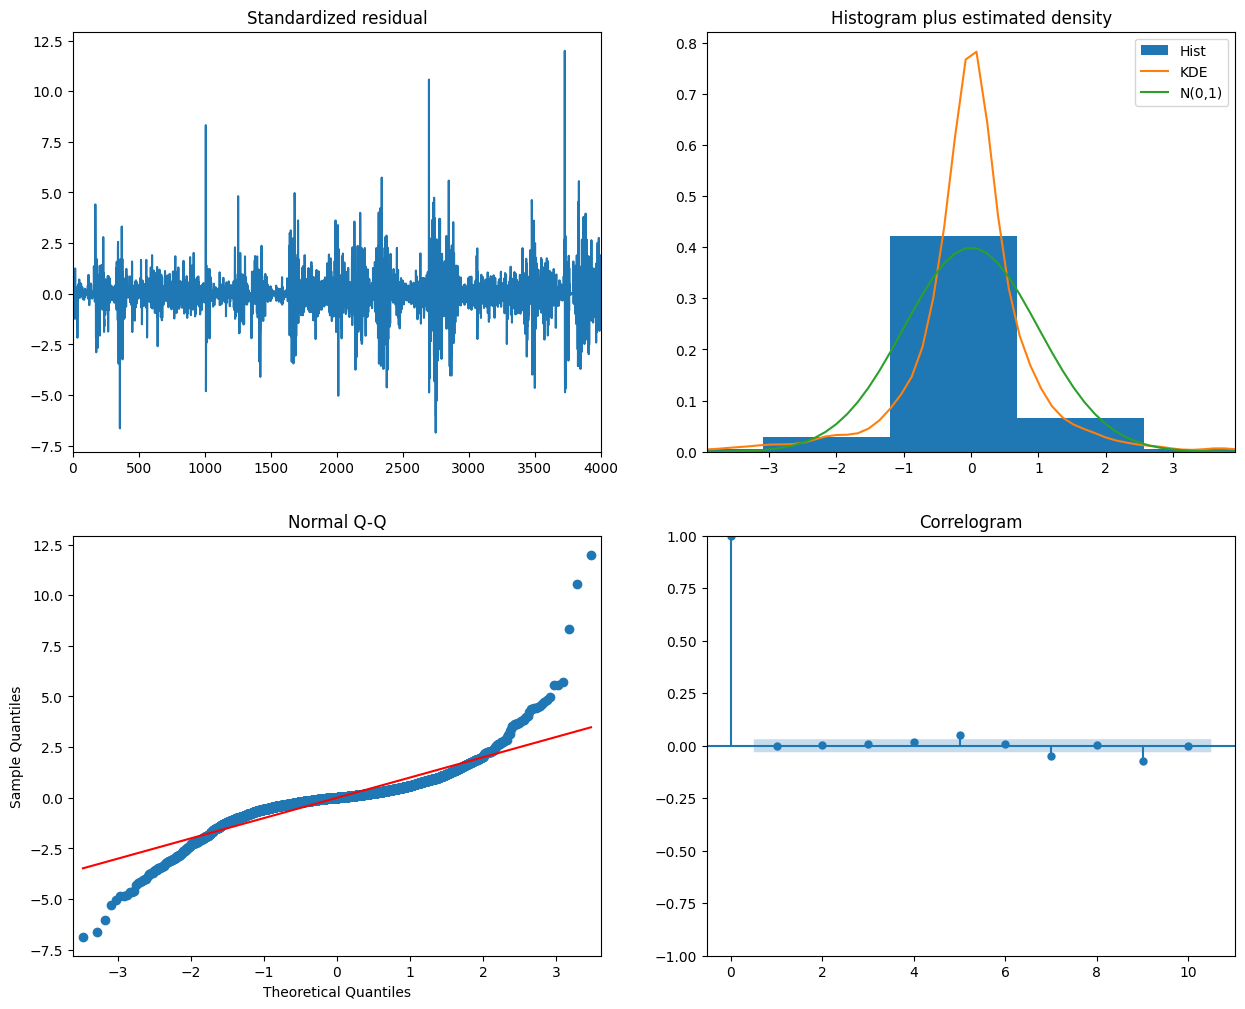

In [38]:
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [39]:
test_data_new

,Date,Arrival,Price
0,2020-12-29,148.0,1000.0
1,2020-12-30,135.0,1200.0
2,2020-12-31,175.0,1000.0
3,2021-01-01,239.0,850.0
4,2021-01-02,177.0,1070.0
...,...,...,...
999,2023-09-24,235.0,700.0
1000,2023-09-25,223.0,700.0
1001,2023-09-26,246.0,600.0
1002,2023-09-27,166.0,550.0


In [40]:
# df['Date'] = pd.to_datetime(df['Date'])

In [41]:
df['Date'] = pd.to_datetime(df['Date'])
train_data_new['Date'] = pd.to_datetime(train_data_new['Date'])
test_data_new['Date'] = pd.to_datetime(test_data_new['Date'])

In [42]:
from datetime import timedelta

In [43]:
# Make predictions on the training data
train_predictions_new, _ = SARIMAX_model.predict_in_sample(return_conf_int=True)

# Store the training predictions with dates
train_predictions_df_new = pd.DataFrame({'Date': train_data_new['Date'], 'Predicted_Price': train_predictions_new})
train_predictions_df_new.set_index('Date', inplace=True)

# Make predictions on the test data
test_predictions_new, conf_int =SARIMAX_model.predict(n_periods=len(test_data_new), return_conf_int=True)

# Store the test predictions with dates
test_predictions_df_new = pd.DataFrame({'Date': test_data_new['Date'], 'Predicted_Price': test_predictions_new})
test_predictions_df_new.set_index('Date', inplace=True)

# Forecast 10 steps ahead
forecast_steps = 100
forecast_new, conf_int_forecast =SARIMAX_model.predict(n_periods=forecast_steps, return_conf_int=True)

# Create a DataFrame for the forecasted values with future dates
future_dates = pd.date_range(df['Date'].max() + timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df_new = pd.DataFrame({'Date': future_dates, 'Forecasted_Price': forecast_new})
forecast_df_new.set_index('Date', inplace=True)

In [44]:
forecast_df_new

,Forecasted_Price
Date,
2023-09-29,1290.734032
2023-09-30,1162.346457
2023-10-01,1232.644981
2023-10-02,1138.120155
2023-10-03,1154.230484
...,...
2024-01-02,-182.482341
2024-01-03,-175.450007
2024-01-04,-381.116528


In [45]:
test_predictions_df_new_list = test_predictions_df_new['Predicted_Price'].iloc[1004:].to_list().copy()

In [46]:
len(test_predictions_df_new_list)

1004

In [47]:
len(dates_list)

1004

In [48]:
data = {
    "Date": dates_list,
    "Predicted_Price": test_predictions_df_new_list
}

new_df = pd.DataFrame(data)
new_df.set_index('Date', inplace=True)
test_predictions_df_new=new_df.copy()

In [49]:
train_data_new['Date'] = pd.to_datetime(train_data_new['Date'])
test_data_new['Date'] = pd.to_datetime(test_data_new['Date'])
train_predictions_df_new.index = pd.to_datetime(train_predictions_df_new.index)
test_predictions_df_new.index = pd.to_datetime(test_predictions_df_new.index)
forecast_df_new.index = pd.to_datetime(forecast_df_new.index)

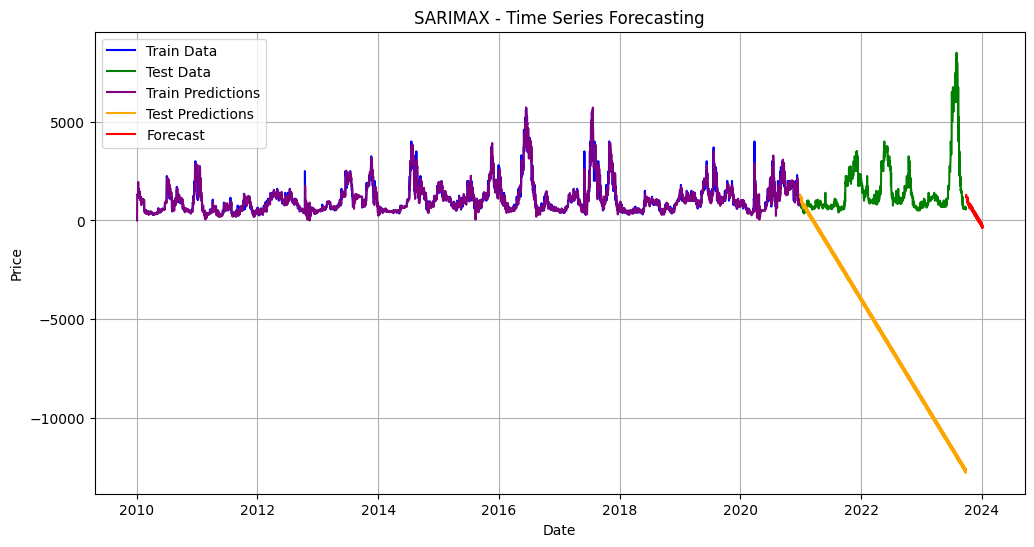

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_new['Date'], train_data_new['Price'], label='Train Data', color='blue')
plt.plot(test_data_new['Date'], test_data_new['Price'], label='Test Data', color='green')
plt.plot(train_predictions_df_new.index, train_predictions_df_new['Predicted_Price'], label='Train Predictions', color='purple')
plt.plot(test_predictions_df_new.index, test_predictions_df_new['Predicted_Price'], label='Test Predictions', color='orange')
plt.plot(forecast_df_new.index, forecast_df_new['Forecasted_Price'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('SARIMAX - Time Series Forecasting')
plt.grid(True)
plt.show()

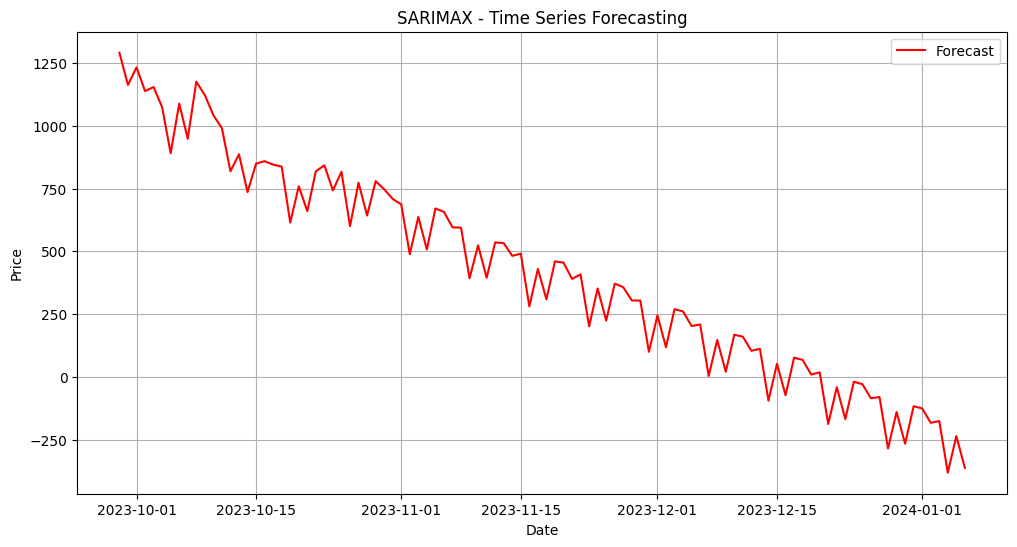

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_df_new.index, forecast_df_new['Forecasted_Price'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('SARIMAX - Time Series Forecasting')
plt.grid(True)
plt.show()

In [52]:
test_predictions_df_new

,Predicted_Price
Date,
2020-12-29,1290.734032
2020-12-30,1162.346457
2020-12-31,1232.644981
2021-01-01,1138.120155
2021-01-02,1154.230484
...,...
2023-09-24,-12585.351762
2023-09-25,-12790.996258
2023-09-26,-12645.051992


In [53]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_auto_arima=math.sqrt(mean_squared_error(test_predictions_df_new['Predicted_Price'],test_data_new['Price']))
print('Mean value of price is : {}. Root Mean Squared Error is :{}'.format(mean(test_data_new['Price']),rmse_auto_arima))

Mean value of price is : 1502.424745462594. Root Mean Squared Error is :8616.677729487728


In [54]:
from sklearn.metrics import mean_squared_error
y_true = test_data_new["Price"]
y_pred = test_predictions_df_new

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calculate the range of the target variable
y_range = np.max(y_true) - np.min(y_true)

# Calculate the RMSE as a percentage of the range
rmse_percentage = (rmse / y_range) * 100

# Calculate NRMSE (normalized by mean of observed values)
nrmse = rmse / np.mean(y_true)
print(f'Normalized RMSE (NRMSE): {nrmse:.2f}')

print(f'Mean Squared Error (MSE) : {mse:.2f}')
print(f'Root Mean Squared Error (RMSE) : {rmse:.2f}')
print(f'Root Mean Squared Error (RMSE) as a percentage of the range: {rmse_percentage:.2f}%')

Normalized RMSE (NRMSE): 5.74
Mean Squared Error (MSE) : 74247135.09
Root Mean Squared Error (RMSE) : 8616.68
Root Mean Squared Error (RMSE) as a percentage of the range: 105.73%


In [55]:
# Convert the 'Date' column to datetime format
test_data_new['Date'] = pd.to_datetime(test_data_new['Date'])

# Set 'Date' as the index for time series analysis
test_data_new.set_index('Date', inplace=True)

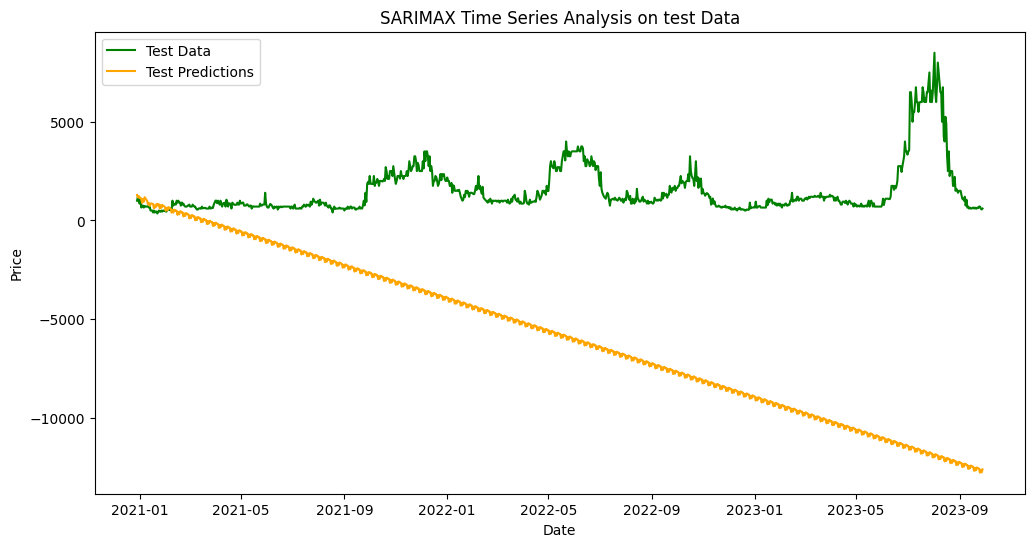

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_new.index, test_data_new['Price'], label='Test Data', color='green')
plt.plot(test_predictions_df_new.index, test_predictions_df_new, label='Test Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('SARIMAX Time Series Analysis on test Data')
plt.show()